In [1]:
import numpy as np
import torch
import math
import os
import random

import warnings
warnings.filterwarnings('ignore')

from modules.utils import GlobalConfig, TrainConfig, Logger, paint, get_env, simulate_episode, evaluate
from modules.DQN import DQN
from modules.reward import Reward
from modules.preprocess import preprocess

from tqdm.auto import trange

global_config = GlobalConfig(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    n_actions=5,
    n_predators=5,
    n_masks=5,
    map_size=40
)

# TRAIN

Saving plots...


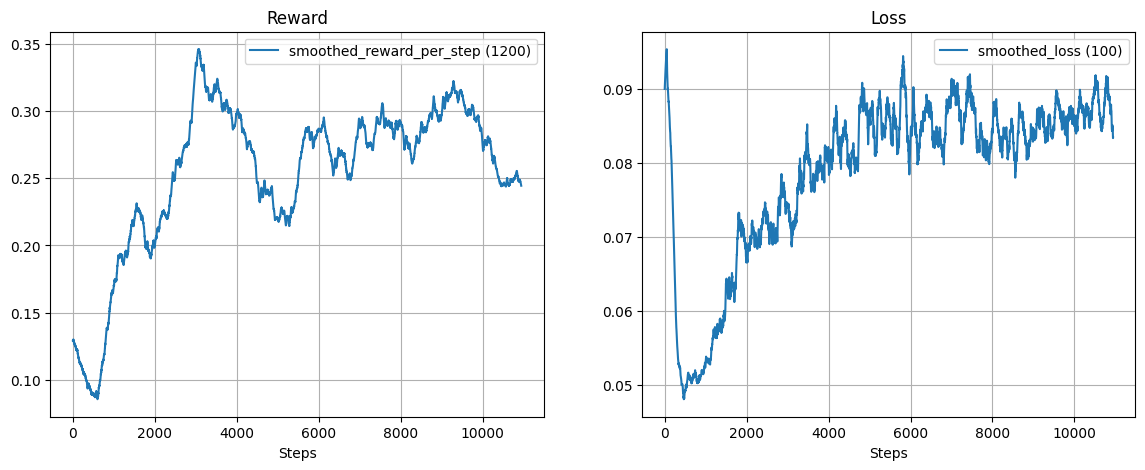

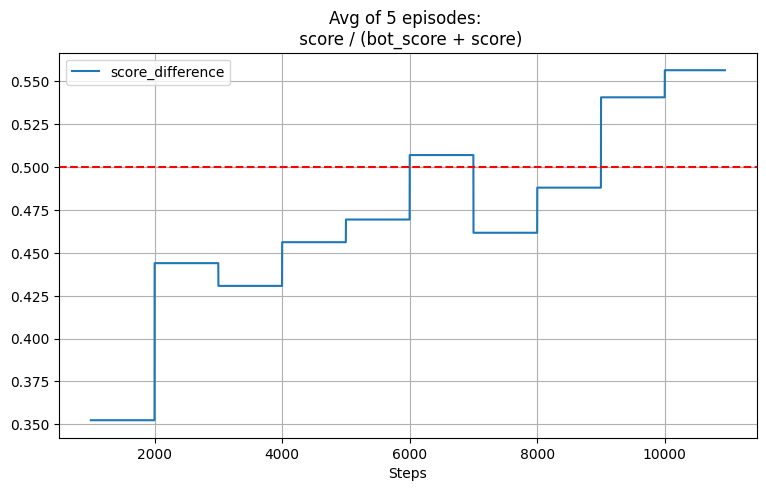

In [3]:
train_config = TrainConfig(
    description='final model',
    max_steps_for_episode=300,
    gamma=0.9,
    initial_steps=1000,  # 3000
    steps=30_000,
    steps_per_update=3,
    steps_per_paint=250,
    steps_per_eval=1_000,
    buffer_size=10_000,
    batch_size=64,
    learning_rate=0.001,
    eps_start=0.9,
    eps_end=0.05,
    eps_decay=1000,
    tau=0.005,  # the update rate of the target network, was 0.005
    reward_params=dict(
        w_dist_change=-0.5,
        w_kill_prey=1.,
        w_kill_enemy=3.,
        w_kill_bonus=1.3,
        standing_still_penalty=-0.7,
        gamma_for_bonus_count=0.5,
        n_nearest_targets=2,
    ),
    seed=1234
)


def train(model, logger, global_config, train_config):
    def get_difficulty():
        return min(logger.steps_done, train_config.steps - train_config.buffer_size) / (train_config.steps - train_config.buffer_size)                         

    # INITIAL STEPS
    if len(model.buffer) < train_config.initial_steps:
        env = get_env(global_config, train_config, difficulty=get_difficulty())
        state, info = env.reset()
        processed_state = preprocess(state, info)
        r = Reward(global_config, train_config)
        for _ in trange(len(model.buffer), train_config.initial_steps, desc='Initial steps'):
            actions = model.get_actions(processed_state, random=True)
            next_state, done, next_info = env.step(actions)
            next_processed_state = preprocess(next_state, next_info)
            reward = r(processed_state, info, next_processed_state, next_info)
            model.consume_transition(processed_state, actions, next_processed_state, reward, done)
            state, info = (next_state, next_info) if not done else env.reset()
            processed_state = preprocess(state, info)

    # TRAIN
    env = get_env(global_config, train_config, difficulty=get_difficulty())
    state, info = env.reset()
    processed_state = preprocess(state, info)
    r = Reward(global_config, train_config)
    score_difference, loss = None, None
    try:
        for _ in trange(logger.steps_done, train_config.steps, desc='Training'):
            # ========== step ==========================================================
            eps_threshold = train_config.eps_end + \
                (train_config.eps_start - train_config.eps_end) * \
                math.exp(-1. * logger.steps_done / train_config.eps_decay)
            actions = model.get_actions(processed_state, random=(random.random() < eps_threshold))
            next_state, done, next_info = env.step(actions)
            next_processed_state = preprocess(next_state, next_info)
            reward = r(processed_state, info, next_processed_state, next_info)
            model.consume_transition(processed_state, actions, next_processed_state, reward, done)

            if done:
                env = get_env(global_config, train_config, difficulty=get_difficulty())
                state, info = env.reset()
            else:
                state, info = next_state, next_info

            processed_state = preprocess(state, info)

            # ========== updates =======================================================
            if logger.steps_done % train_config.steps_per_update == 0:
                loss = model.update_policy_network()

            model.soft_update_target_network()  # each step

            model.scheduler.step()

            # ========== logs ==========================================================
            if logger.steps_done % train_config.steps_per_eval == 0 and logger.steps_done > 0:
                os.makedirs(logger.curr_subfolder_path + '/gifs', exist_ok=True)
                gif_path = f'{logger.curr_subfolder_path}/gifs/{logger.steps_done}_steps.gif'
                simulate_episode(model, get_difficulty(), gif_path)
                score_difference = evaluate(model, n_episodes=5)

            logger.add('eps', eps_threshold)
            logger.add('reward', reward.mean())
            logger.add('loss', loss)
            logger.add('score_difference', score_difference)   

            if logger.steps_done % train_config.steps_per_paint == 0 and logger.steps_done > 0:
                paint(logger)         

            if logger.steps_done % train_config.steps_per_eval == 0 and logger.steps_done > 0:
                logger.save_model()                

            logger.step()

    except KeyboardInterrupt:
        print('Training interrupted')

    except Exception:
        raise

    finally:
        logger.save()
        logger.save_model()
        paint(logger, save_plots=True)
        return model


model = DQN(global_config, train_config).to(global_config.device).train()
logger = Logger(train_config, model)
model = train(model, logger, global_config, train_config)